# Importations des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf


# Chargement des données

In [ ]:
# Charger les données
df_pro = pd.read_csv('Produits_Combines_2.csv')
df_user = pd.read_csv('Utilisateurs_Tunisie_Updated.csv')
df_rat = pd.read_csv('ratings.csv')

# Affichage de la forme des DataFrames

In [ ]:
print(df_pro.shape)
print(df_user.shape)
print(df_rat.shape)

(4478, 13)
(1000, 5)
(5040, 4)


In [ ]:
df_rat.head()

,user_id,prod_id,rating,timestamp
0,user_1,4451,5,2022-01-24
1,user_1,2206,2,2022-06-01
2,user_1,4125,5,2022-10-13
3,user_1,3687,4,2022-03-22
4,user_1,3877,5,2023-10-06


In [ ]:
df_pro.head()

,id_product,Title,Marque,URL,Price,Original Price,Discount,Category,Sub-Category,Image Path,Product Description,Product Main Image,Manufacturer Logo
0,1,SVR SEBIACLEAR GEL MOUSSANT 400ML,SVR,https://pharma-shop.tn/nettoyage/1536-svr-sebi...,"41,098 TND","51,373 TND",-20%,pharma-shop.tn,853-soins-peau-grasse-mixte-et-acne,C:\Users\broun\downloaded_images\svr-sebiaclea...,"Description : Gel moussant Sébiaclear de SVR, ...",https://pharma-shop.tn/15782-large_default/svr...,https://pharma-shop.tn/img/m/68.jpg
1,2,SVR SEBIACLEAR ACTIVE GEL CORRECTEUR INTENSIF ...,SVR,https://pharma-shop.tn/soins-specifiques/891-s...,"38,229 TND","47,786 TND",-20%,pharma-shop.tn,853-soins-peau-grasse-mixte-et-acne,C:\Users\broun\downloaded_images\svr-sebiaclea...,"Pour les peaux sensibles à tendance acnéique, ...",https://pharma-shop.tn/11978-large_default/svr...,https://pharma-shop.tn/img/m/68.jpg
2,3,AVENE CLEANANCE GEL NETTOYANT 200ML,AVENE,https://pharma-shop.tn/gel-creme-huile/1558-av...,"36,346 TND","40,384 TND",-10%,pharma-shop.tn,853-soins-peau-grasse-mixte-et-acne,C:\Users\broun\downloaded_images\avene-cleanan...,Avène Cleanance Gel Nettoyant 200 ml est un ge...,https://pharma-shop.tn/19335-large_default/ave...,https://pharma-shop.tn/img/m/11.jpg
3,4,SVR SEBIACLEAR ACTIVE TEINTEE 40ML,SVR,https://pharma-shop.tn/soins-teintes/5074-svr-...,"37,130 TND","46,413 TND",-20%,pharma-shop.tn,853-soins-peau-grasse-mixte-et-acne,C:\Users\broun\downloaded_images\svr-sebiaclea...,Description : Pour les peaux sensibles à tenda...,https://pharma-shop.tn/17535-large_default/svr...,https://pharma-shop.tn/img/m/68.jpg
4,5,SVR SEBIACLEAR GEL MOUSSANT RECHARGE 400ML,SVR,https://pharma-shop.tn/gel-creme-huile/11094-s...,"38,758 TND","50,998 TND",-24%,pharma-shop.tn,853-soins-peau-grasse-mixte-et-acne,C:\Users\broun\downloaded_images\svr-sebiaclea...,Nettoyant sans savon qui purifie et désincrust...,https://pharma-shop.tn/17421-large_default/svr...,https://pharma-shop.tn/img/m/68.jpg


# Nettoyage des Données


## 1. Suppression des Valeurs Manquantes

In [ ]:
print(df_pro.isnull().sum())


id_product                0
Title                     0
Marque                   27
URL                       0
Price                     0
Original Price         2878
Discount               2878
Category                  0
Sub-Category              0
Image Path                0
Product Description     213
Product Main Image        0
Manufacturer Logo        78
dtype: int64


In [ ]:
print(df_user.isnull().sum())


id                  0
age                 0
sexe                0
ville               0
historique_achat    0
dtype: int64


In [ ]:
print(df_rat.isnull().sum())

user_id      0
prod_id      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Remplacer les valeurs NaN dans la colonne 'Discount' par '0%'
df_pro['Discount'] = df_pro['Discount'].fillna('0%')



In [ ]:
# Remplacer les valeurs NaN dans la colonne 'Price_Original' par les valeurs de la colonne 'Price'
df_pro['Original Price'] = df_pro['Original Price'].fillna(df_pro['Price'])

In [ ]:
df_pro.isnull().sum()

,0
id_product,0
Title,0
Marque,27
URL,0
Price,0
Original Price,0
Discount,0
Category,0
Sub-Category,0
Image Path,0


In [ ]:
# Fonction pour extraire le premier mot d'une chaîne
def get_first_word(title):
    return title.split()[0] if pd.notnull(title) else None

# Remplacer les valeurs manquantes dans 'Marque' par le premier mot de 'Title'
df_pro['Marque'] = df_pro['Marque'].fillna(df_pro['Title'].apply(get_first_word))

# Vérifier les valeurs manquantes après le remplacement
print(df_pro['Marque'].isnull().sum())

# Afficher les premières lignes pour vérifier
print(df_pro[['Title', 'Marque']].head(200))


0
                                                 Title           Marque
0                    SVR SEBIACLEAR GEL MOUSSANT 400ML              SVR
1    SVR SEBIACLEAR ACTIVE GEL CORRECTEUR INTENSIF ...              SVR
2                  AVENE CLEANANCE GEL NETTOYANT 200ML            AVENE
3                   SVR SEBIACLEAR ACTIVE TEINTEE 40ML              SVR
4           SVR SEBIACLEAR GEL MOUSSANT RECHARGE 400ML              SVR
..                                                 ...              ...
195    Debada Trousse soins visage peau mixte à grasse           Debada
196  LIRENE ACID POWER REVITALIZING PERFECTING CREA...           Lirene
197          NUXE REVE DE MIEL SURGRAS NETTOYANT 750ML             NUXE
198            NATURA SIBERICA PEELING PURIFIANT ET...  NATURA SIBERICA
199      GARNIER PURE ACTIVE NETTOYANT 3 EN 1 - 150 ML          GARNIER

[200 rows x 2 columns]


In [ ]:
# Fonction pour extraire tous les mots sauf le premier d'une chaîne
def get_rest_of_words(title):
    if pd.notnull(title):
        words = title.split()
        return ' '.join(words[1:]) if len(words) > 1 else ''  # Si plus d'un mot, retourner tous sauf le premier
    return None

# Remplacer les valeurs manquantes dans 'Product Description' par le reste du titre sans le premier mot
df_pro['Product Description'] = df_pro['Product Description'].fillna(df_pro['Title'].apply(get_rest_of_words))

# Vérifier les valeurs manquantes après le remplacement
print(df_pro['Product Description'].isnull().sum())

# Afficher les premières lignes pour vérifier
print(df_pro[['Title', 'Product Description']].head())


0
                                               Title  \
0                  SVR SEBIACLEAR GEL MOUSSANT 400ML   
1  SVR SEBIACLEAR ACTIVE GEL CORRECTEUR INTENSIF ...   
2                AVENE CLEANANCE GEL NETTOYANT 200ML   
3                 SVR SEBIACLEAR ACTIVE TEINTEE 40ML   
4         SVR SEBIACLEAR GEL MOUSSANT RECHARGE 400ML   

                                 Product Description  
0  Description : Gel moussant Sébiaclear de SVR, ...  
1  Pour les peaux sensibles à tendance acnéique, ...  
2  Avène Cleanance Gel Nettoyant 200 ml est un ge...  
3  Description : Pour les peaux sensibles à tenda...  
4  Nettoyant sans savon qui purifie et désincrust...  


In [ ]:
print(df_pro.isnull().sum())


id_product              0
Title                   0
Marque                  0
URL                     0
Price                   0
Original Price          0
Discount                0
Category                0
Sub-Category            0
Image Path              0
Product Description     0
Product Main Image      0
Manufacturer Logo      78
dtype: int64


In [ ]:
# Vérifier s'il y a des valeurs NaN dans l'ensemble du DataFrame
missing_values = df_pro.isnull().sum()

# Afficher le nombre de valeurs NaN par colonne
print("Nombre de valeurs NaN par colonne :")
print(missing_values)

# Vérifier si le DataFrame contient au moins une valeur NaN
if missing_values.any():
    print("Le DataFrame contient des valeurs NaN.")
else:
    print("Le DataFrame ne contient aucune valeur NaN.")


Nombre de valeurs NaN par colonne :
id_product              0
Title                   0
Marque                  0
URL                     0
Price                   0
Original Price          0
Discount                0
Category                0
Sub-Category            0
Image Path              0
Product Description     0
Product Main Image      0
Manufacturer Logo      78
dtype: int64
Le DataFrame contient des valeurs NaN.


## 2. Suppression des Doublons

In [ ]:
# Vérifier s'il y a des lignes dupliquées dans l'ensemble du DataFrame
duplicates = df_pro.duplicated()

# Afficher le nombre de doublons
print(f"Nombre de doublons : {duplicates.sum()}")

# Afficher les lignes dupliquées si elles existent
if duplicates.any():
    print("Lignes dupliquées :")
    print(df_pro[duplicates])
else:
    print("Aucune ligne dupliquée.")


Nombre de doublons : 0
Aucune ligne dupliquée.


In [ ]:
# Vérifier s'il y a des lignes dupliquées dans l'ensemble du DataFrame
duplicates = df_rat.duplicated()

# Afficher le nombre de doublons
print(f"Nombre de doublons : {duplicates.sum()}")

# Afficher les lignes dupliquées si elles existent
if duplicates.any():
    print("Lignes dupliquées :")
    print(df_rat[duplicates])
else:
    print("Aucune ligne dupliquée.")


Nombre de doublons : 0
Aucune ligne dupliquée.


In [ ]:
# Vérifier s'il y a des lignes dupliquées dans l'ensemble du DataFrame
duplicates = df_user.duplicated()

# Afficher le nombre de doublons
print(f"Nombre de doublons : {duplicates.sum()}")

# Afficher les lignes dupliquées si elles existent
if duplicates.any():
    print("Lignes dupliquées :")
    print(df_user[duplicates])
else:
    print("Aucune ligne dupliquée.")


Nombre de doublons : 0
Aucune ligne dupliquée.


# Prétraitement des Données


* cette section du code prépare les caractéristiques des produits en encodant les données catégorielles et textuelles en valeurs numériques, et en nettoyant et convertissant les prix .

In [ ]:
product_features = df_pro[['Price', 'Product Description','Marque']].copy()



# Créer des instances de LabelEncoder
marque_encoder = LabelEncoder()


# Encoder la colonne 'Marque'
product_features ['Marque'] = marque_encoder.fit_transform(df_pro['Marque'])

product_features = pd.get_dummies(product_features, columns=['Product Description'])


product_features['Price'] = product_features['Price'].str.replace('TND','').str.replace(',', '.').astype(float)


In [ ]:
# Modifier les noms des colonnes du DataFrame
nouveaux_noms_colonnes = ['user_id', 'id_product', 'rating', 'timestamp']
df_rat.columns = nouveaux_noms_colonnes

prod_dataset = df_pro[['id_product', 'Title']]
prod_dataset.head()


,id_product,Title
0,1,SVR SEBIACLEAR GEL MOUSSANT 400ML
1,2,SVR SEBIACLEAR ACTIVE GEL CORRECTEUR INTENSIF ...
2,3,AVENE CLEANANCE GEL NETTOYANT 200ML
3,4,SVR SEBIACLEAR ACTIVE TEINTEE 40ML
4,5,SVR SEBIACLEAR GEL MOUSSANT RECHARGE 400ML


* Cette ligne fusionne ( **merge** ) deux DataFrames, df_rat (qui contient les évaluations des utilisateurs) et prod_dataset (qui contient les informations sur les produits), en un seul DataFrame appelé merged_dataset.
* Le type de fusion utilisé est **inner** , ce qui signifie que seuls les enregistrements ayant des correspondances dans les deux DataFrames sont inclus dans le DataFrame final. Autrement dit, seuls les produits ayant des évaluations dans df_rat et des informations dans prod_dataset seront inclus.
* La fusion est effectuée sur la colonne **id_product** , qui est présente dans les deux DataFrames. Cette colonne est utilisée comme clé pour associer les enregistrements des deux ensembles de données.

In [ ]:
merged_dataset = pd.merge(df_rat, prod_dataset, how='inner', on='id_product')
merged_dataset.head()

,user_id,id_product,rating,timestamp,Title
0,user_1,4451,5,2022-01-24,VITABIOTICS PERFECTIL PLATINIUM RADIANCE 30...
1,user_1,2206,2,2022-06-01,GAMARDE CREME DE DOUCHE APAISANTE 200ML
2,user_480,2206,4,2022-12-02,GAMARDE CREME DE DOUCHE APAISANTE 200ML
3,user_815,2206,1,2020-02-07,GAMARDE CREME DE DOUCHE APAISANTE 200ML
4,user_1,4125,5,2022-10-13,3 Chênes Huile Onagre 150 Capsules


In [ ]:
# Création d'un ensemble de données final raffiné avec un identifiant d'utilisateur unique, une combinaison de noms de films et leurs notes
refined_dataset = merged_dataset.groupby(by=['user_id','id_product','Title'], as_index=False).agg({"rating": "mean"})
refined_dataset.head(200)


,user_id,id_product,Title,rating
0,user_1,2206,GAMARDE CREME DE DOUCHE APAISANTE 200ML,2.0
1,user_1,2628,TITANIA FOOT CARE BEURRE POUR PIEDS 250 ML,3.0
2,user_1,2671,K-REINE CRÈME DE MODELAGE MAINS Citron et Aloé...,2.0
3,user_1,3687,HELIOCARE ORAL CAPSULES 60 CAPSULES,4.0
4,user_1,3877,NATURALIUM QUICK DRAINEUR 300ML,5.0
...,...,...,...,...
195,user_132,4147,FERTILIS FEMME 120 GÉLULES,5.0
196,user_132,4331,FORTIMEL EXTRA VANILLE 200ML,4.0
197,user_133,90,FILORGA AGE-PURIFY FLUID DOUBLE CORRECTION 50ML,3.0
198,user_133,1913,DUCRAY KELUAL DS CREME APAISANTE...,5.0


In [ ]:
# Data preparation
refined_dataset['user_id'] = refined_dataset['user_id'].astype('category').cat.codes


n_users =refined_dataset['user_id'].nunique()
n_produits = refined_dataset['id_product'].nunique()
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])

In [ ]:
refined_dataset.columns

Index(['user_id', 'id_product', 'Title', 'rating'], dtype='object')

In [ ]:
# Merge rating data with product features
merged_data = pd.merge(refined_dataset,product_features,left_on='id_product', right_index=True)

merged_data.columns

Index(['user_id', 'id_product', 'Title', 'rating', 'Price', 'Marque',
       'Product Description_ ', 'Product Description_    ',
       'Product Description_   Composition:AQUA (WATER), CITRIC ACID, HYDROXYPROPYL STARCH PHOSPHATE, ALPHA-ARBUTIN, ASCORBYLGLUCOSIDE, AMINOMETHYL PROPANOL, ALCOHOL DENAT., SODIUM HYDROXIDE, DICAPRYLYL CARBONATE, PHENOXYETHANOL, METHYLPARABEN, PROPYLPARABEN, GLYCYRRHIZA GLABRA (LICORICE) ROOT EXTRACT, SODIUM METABISULFITE, ETHYLPARABEN, TOCOPHEROL.  ConseIl d'Utilisation:  Il est recommandé d'Appliquer UNITONE 4 reveal serum 1 à 2 fois par jour sur les zones à traiter. Peut être utilisé le jour.',
       'Product Description_  DESCRIPTION :  Adoptez une « beauty routine » grâce à notre nouvelle gamme de crèmes pour le visage : 24H et Q10. La crème de jour BYPHASSE lift instant associe la coenzyme Q10, un actif raffermissant efficace avec l’acide hyaluronique qui améliore l’élasticité de la peau.  Résultat beauté : Votre peau est douce et lisse, elle retrouv

# Division de données


In [ ]:
# Normalize labels (y)
scaler = MinMaxScaler()
merged_data['rating'] = scaler.fit_transform(merged_data[['rating']])

# Prepare features and labels
X = merged_data[['user_id','id_product']].values
y = merged_data['rating'].values
content_features = merged_data.drop(columns=['user_id', 'id_product', 'Title', 'rating']).values

# Convert data to float32
X = X.astype('float32')
y = y.astype('float32')
content_features = content_features.astype('float32')

# Split data into training and test sets
X_train, X_test, y_train, y_test, content_train, content_test = train_test_split(X, y, content_features, test_size=0.2, random_state=42)

# Encoders for user and product IDs
user_enc = LabelEncoder()
item_enc = LabelEncoder()

# Fit the encoders on the user and product IDs
user_enc.fit(refined_dataset['user_id'])
item_enc.fit(refined_dataset['id_product'])


# Transform the user and product IDs in the training set
X_train[:, 0] = user_enc.transform(X_train[:, 0])
X_train[:, 1] = item_enc.transform(X_train[:, 1])
X_test[:, 0] = user_enc.transform(X_test[:, 0])
X_test[:, 1] = item_enc.transform(X_test[:, 1])

# Normalisation des labels
y_train = (y_train - min_rating) / (max_rating - min_rating)
y_test = (y_test - min_rating) / (max_rating - min_rating)


In [ ]:
def create_model(n_users, n_produits, n_factors, content_feature_size):
    user_input = Input(shape=(1,), name='user_input')
    produit_input = Input(shape=(1,), name='produit_input')
    content_input = Input(shape=(content_feature_size,), name='content_input')

    user_embedding = Embedding(n_users, n_factors, input_length=1)(user_input)
    produit_embedding = Embedding(n_produits, n_factors, input_length=1)(produit_input)

    user_vecs = Flatten()(user_embedding)
    produit_vecs = Flatten()(produit_embedding)

    input_vecs = Concatenate()([user_vecs, produit_vecs, content_input])

    x = Dense(256, kernel_initializer='he_normal')(input_vecs)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(128, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(64, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(32, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(16, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    # Couche de sortie pour la régression
    x = Dense(1)(x)
    x= Activation('sigmoid')(x)



    model = Model(inputs=[user_input, produit_input, content_input], outputs=x)
    return model

In [ ]:
# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_fold_histories = []
mse_scores = []
mae_scores = []

content_feature_size = content_features.shape[1]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3579 - mse: 0.3579
Epoch 1: val_loss improved from inf to 0.06796, saving model to best_model_fold_1.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.3551 - mse: 0.3551 - val_loss: 0.0680 - val_mse: 0.0680 - learning_rate: 1.0000e-04
Epoch 2/200
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2371 - mse: 0.2371
Epoch 2: val_loss improved from 0.06796 to 0.03345, saving model to best_model_fold_1.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2352 - mse: 0.2352 - val_loss: 0.0335 - val_mse: 0.0335 - learning_rate: 1.0000e-04
Epoch 3/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1571 - mse: 0.1571
Epoch 3: val_loss improved from 0.03345 to 0.02867, saving model to best_model_fold_1.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1563 - mse: 0.1563 - val_loss: 0.0287 - val_mse: 0.0287 - learning_rate: 1.0000e-04
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1127 - mse: 0.1127
Ep

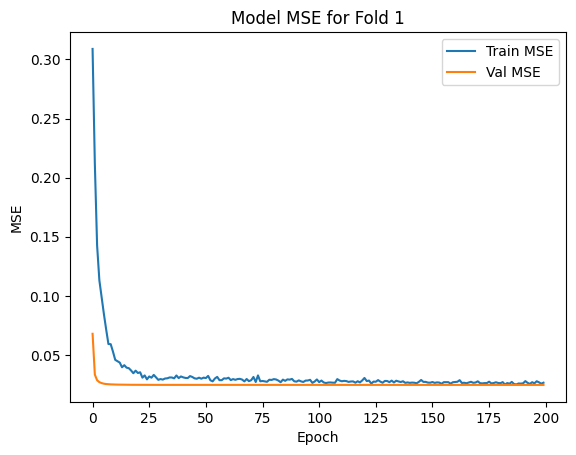

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5411 - mse: 0.5411
Epoch 1: val_loss improved from inf to 0.06183, saving model to best_model_fold_2.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5370 - mse: 0.5370 - val_loss: 0.0618 - val_mse: 0.0618 - learning_rate: 1.0000e-04
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3105 - mse: 0.3105
Epoch 2: val_loss improved from 0.06183 to 0.03624, saving model to best_model_fold_2.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3097 - mse: 0.3097 - val_loss: 0.0362 - val_mse: 0.0362 - learning_rate: 1.0000e-04
Epoch 3/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2106 - mse: 0.2106
Epoch 3: val_loss improved from 0.03624 to 0.02950, saving model to best_model_fold_2.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2099 - mse: 0.2099 - val_loss: 0.0295 - val_mse: 0.0295 - learning_rate: 1.0000e-04
Epoch 4/200
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1451 - mse: 0.1451
Ep

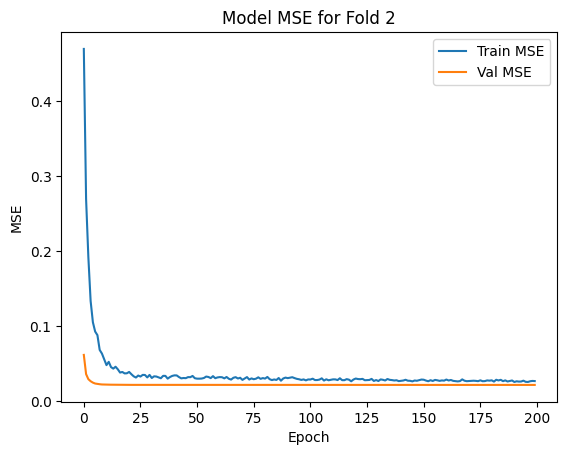

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5112 - mse: 0.5112
Epoch 1: val_loss improved from inf to 0.03062, saving model to best_model_fold_3.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.5069 - mse: 0.5069 - val_loss: 0.0306 - val_mse: 0.0306 - learning_rate: 1.0000e-04
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3050 - mse: 0.3050
Epoch 2: val_loss improved from 0.03062 to 0.02827, saving model to best_model_fold_3.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3046 - mse: 0.3046 - val_loss: 0.0283 - val_mse: 0.0283 - learning_rate: 1.0000e-04
Epoch 3/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1894 - mse: 0.1894
Epoch 3: val_loss improved from 0.02827 to 0.02702, saving model to best_model_fold_3.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1892 - mse: 0.1892 - val_loss: 0.0270 - val_mse: 0.0270 - learning_rate: 1.0000e-04
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1544 - mse: 0.1544
Ep

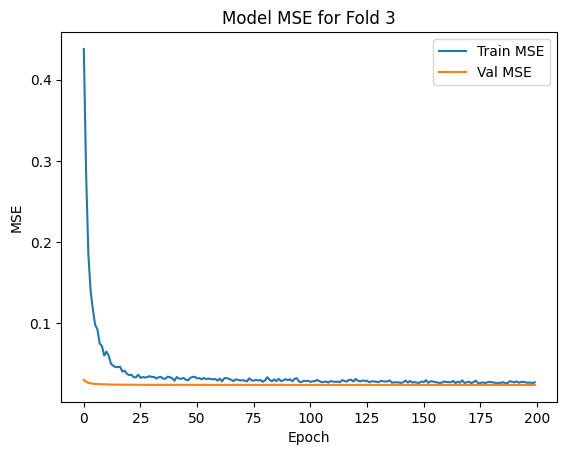

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1622 - mse: 0.1622
Epoch 1: val_loss improved from inf to 0.03367, saving model to best_model_fold_4.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1607 - mse: 0.1607 - val_loss: 0.0337 - val_mse: 0.0337 - learning_rate: 1.0000e-04
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0916 - mse: 0.0916
Epoch 2: val_loss improved from 0.03367 to 0.03041, saving model to best_model_fold_4.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0915 - mse: 0.0915 - val_loss: 0.0304 - val_mse: 0.0304 - learning_rate: 1.0000e-04
Epoch 3/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0575 - mse: 0.0575
Epoch 3: val_loss improved from 0.03041 to 0.02819, saving model to best_model_fold_4.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0282 - val_mse: 0.0282 - learning_rate: 1.0000e-04
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0445 - mse: 0.0445
Ep

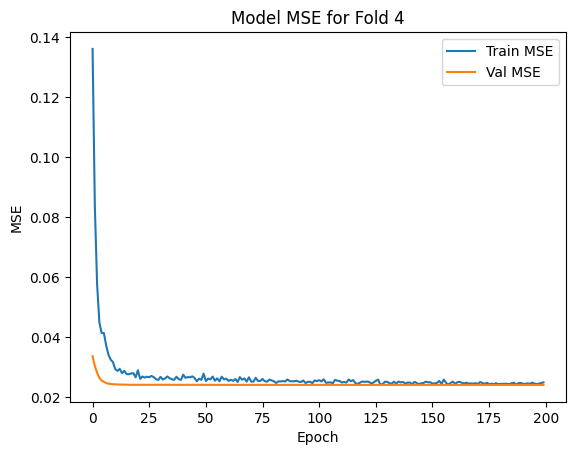

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2605 - mse: 0.2605
Epoch 1: val_loss improved from inf to 0.03036, saving model to best_model_fold_5.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.2595 - mse: 0.2595 - val_loss: 0.0304 - val_mse: 0.0304 - learning_rate: 1.0000e-04
Epoch 2/200
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1588 - mse: 0.1588
Epoch 2: val_loss improved from 0.03036 to 0.02623, saving model to best_model_fold_5.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1580 - mse: 0.1580 - val_loss: 0.0262 - val_mse: 0.0262 - learning_rate: 1.0000e-04
Epoch 3/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1109 - mse: 0.1109
Epoch 3: val_loss improved from 0.02623 to 0.02543, saving model to best_model_fold_5.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1107 - mse: 0.1107 - val_loss: 0.0254 - val_mse: 0.0254 - learning_rate: 1.0000e-04
Epoch 4/200
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0930 - mse: 0.0930
Ep

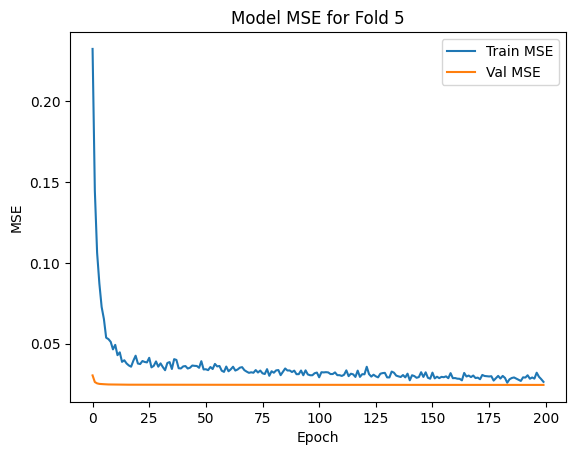

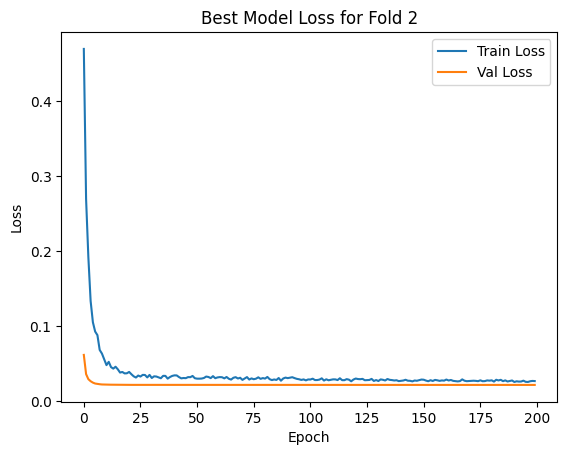

Train MSE scores: [0.023709578, 0.024433369, 0.023779787, 0.023855904, 0.023779416]
Validation MSE scores: [0.024711017, 0.02185082, 0.02444857, 0.024111189, 0.024460683]
Validation MAE scores: [0.12842454, 0.119229, 0.12845467, 0.12632318, 0.12915443]
Mean Train MSE: 0.02391161024570465
Mean Validation MSE: 0.02391645684838295
Mean Validation MAE: 0.12631717324256897
Best model path: best_model_fold_2.keras


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import KFold
# Initialisation
best_model_history = None
best_val_mse = float('inf')
best_model_index = -1
mse_scores = []
mae_scores = []
k_fold_histories = []
train_mse_scores = []


# Boucle sur les plis
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Préparation des données avec les caractéristiques supplémentaires
    X_train_array_fold = [X_train_fold[:, 0], X_train_fold[:, 1], content_train[train_index]]
    X_val_array_fold = [X_val_fold[:, 0], X_val_fold[:, 1], content_train[val_index]]

    # Création du modèle
    model = create_model(n_users, n_produits, n_factors=150, content_feature_size=content_feature_size)

    # Early Stopping, ModelCheckpoint et ReduceLROn
    Plateau

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{i+1}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

    # Ajustement du taux d'apprentissage
    optimizer = Adam(learning_rate=0.0001)  # Réajuster le taux d'apprentissage

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    # Entraînement
    history = model.fit(
        x=X_train_array_fold,
        y=y_train_fold,
        batch_size=64,  # Augmenter la taille du batch
        epochs=200,
        verbose=1,
        validation_data=(X_val_array_fold, y_val_fold),
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    k_fold_histories.append(history)

    # Prédictions pour le fold actuel

    train_predictions = model.predict(X_train_array_fold)

    val_predictions = model.predict(X_val_array_fold)
    val_mse = mean_squared_error(y_val_fold, val_predictions)
    val_mae = mean_absolute_error(y_val_fold, val_predictions)
    train_mse = mean_squared_error(y_train_fold, train_predictions)
    train_mse_scores.append(train_mse)

    mse_scores.append(val_mse)
    mae_scores.append(val_mae)

    # Affichage des pertes pour ce fold
    plt.figure()
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title(f'Model MSE for Fold {i+1}')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Correcting the file extension for loading the best model
best_model_index = np.argmin([min(history.history['val_loss']) for history in k_fold_histories])
best_model_path = f'best_model_fold_{best_model_index+1}.keras'  # Corrected extension
best_model = tf.keras.models.load_model(best_model_path)

# Affichage des pertes pour le meilleur modèle
best_history = k_fold_histories[best_model_index]
plt.figure()
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title(f'Best Model Loss for Fold {best_model_index+1}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print(f"Train MSE scores: {train_mse_scores}")
print(f"Validation MSE scores: {mse_scores}")
print(f"Validation MAE scores: {mae_scores}")
print(f"Mean Train MSE: {np.mean(train_mse_scores)}")
print(f"Mean Validation MSE: {np.mean(mse_scores)}")
print(f"Mean Validation MAE: {np.mean(mae_scores)}")
print(f"Best model path: {best_model_path}")


In [ ]:
# Évaluation du modèle sur les données de test
X_test_array = [X_test[:, 0], X_test[:, 1], content_test]
test_predictions = best_model.predict(X_test_array)
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE: 0.023195801302790642
Test MAE: 0.12413423508405685


Dimensions des caractéristiques des produits utilisées pendant l'entraînement : 2793
Dimensions des caractéristiques des produits actuelles : 2793
ID utilisateur encodé: [450]
L'utilisateur 450 a vu les produits: []
Produits non vus pour l'utilisateur 450: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (affichage des 10 premiers)
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Notes prédites pour l'utilisateur 450: [[2.0249496e-35]
 [4.2346774e-35]
 [1.3381313e-09]
 [5.3403248e-35]
 [3.9463702e-35]
 [3.8780914e-29]
 [4.1849463e-34]
 [4.8324609e-14]
 [2.5111108e-11]
 [8.9560157e-38]] (affichage des 10 premiers)
Top 10 recommandations de produits pour l'utilisateur 450:
[3784 3814 3783 3395 3649 3781 3238 3779 1181 1768]


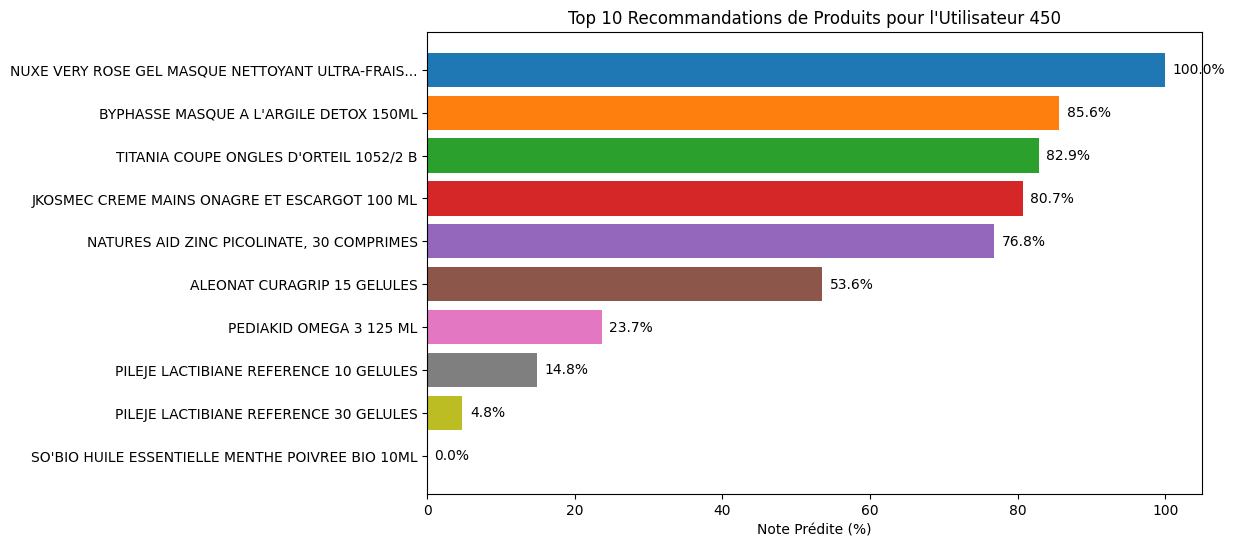

In [ ]:
# Obtenir les dimensions des caractéristiques des produits utilisées pendant l'entraînement
trained_product_features_shape = best_model.input[2].shape[1]

# Afficher les dimensions pour déboguer
print(f"Dimensions des caractéristiques des produits utilisées pendant l'entraînement : {trained_product_features_shape}")
print(f"Dimensions des caractéristiques des produits actuelles : {product_features.shape[1]}")

# Si les dimensions ne correspondent pas, ajuster les caractéristiques des produits
if product_features.shape[1] != trained_product_features_shape:
    print("Les dimensions des caractéristiques des produits ne correspondent pas. Ajustement nécessaire.")
    # Sélectionner uniquement les colonnes utilisées pendant l'entraînement
    product_features_adjusted = product_features.iloc[:, :trained_product_features_shape]
else:
    product_features_adjusted = product_features

def recommender_system(user_id, model, n_recommendations=10):
    # Encoder l'ID de l'utilisateur
    encoded_user_id = user_enc.transform([user_id])
    print(f"ID utilisateur encodé: {encoded_user_id}")

    # Obtenir les produits vus par l'utilisateur
    seen_products = list(df_rat[df_rat['user_id'] == user_id]['id_product'])
    print(f"L'utilisateur {user_id} a vu les produits: {seen_products}")

    # Obtenir les produits non vus
    unseen_products = [i for i in range(n_produits) if i not in seen_products]
    print(f"Produits non vus pour l'utilisateur {user_id}: {unseen_products[:10]} (affichage des 10 premiers)")

    if not unseen_products:
        print(f"Aucun produit non vu pour l'utilisateur {user_id}.")
        return

    # Créer les tableaux d'entrée pour le modèle
    user_array = np.array([encoded_user_id[0]] * len(unseen_products))
    product_array = np.array(unseen_products)
    content_array = product_features_adjusted.loc[unseen_products].values.astype('float32')

    # Faire des prédictions
    model_input = [user_array, product_array, content_array]
    predicted_ratings = model.predict(model_input)
    print(f"Notes prédites pour l'utilisateur {user_id}: {predicted_ratings[:10]} (affichage des 10 premiers)")

    # Obtenir les meilleures N recommandations
    sorted_indices = np.argsort(predicted_ratings[:, 0])[::-1]
    recommended_product_ids = [unseen_products[i] for i in sorted_indices[:n_recommendations]]
    recommended_products = item_enc.inverse_transform(recommended_product_ids)

    top_predicted_ratings = predicted_ratings[sorted_indices[:n_recommendations], 0]

    # Convertir les notes prédites en pourcentage avec une mise à l'échelle appropriée
    top_predicted_ratings_percentage = (top_predicted_ratings - np.min(top_predicted_ratings)) / (np.max(top_predicted_ratings) - np.min(top_predicted_ratings)) * 100

    print(f"Top {n_recommendations} recommandations de produits pour l'utilisateur {user_id}:")
    print(recommended_products)

    # Obtenir les titres des produits recommandés
    recommended_titles = df_pro[df_pro['id_product'].isin(recommended_products)]['Title'].values

    # Générer une liste de couleurs
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Afficher les résultats dans un graphique en barres avec des pourcentages et des couleurs différentes
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(n_recommendations), top_predicted_ratings_percentage, color=colors[:n_recommendations], align='center')
    plt.yticks(range(n_recommendations), recommended_titles)
    plt.gca().invert_yaxis()
    plt.xlabel('Note Prédite (%)')
    plt.title(f'Top {n_recommendations} Recommandations de Produits pour l\'Utilisateur {user_id}')

    # Ajouter des étiquettes de pourcentage aux barres
    for bar, rating in zip(bars, top_predicted_ratings_percentage):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{rating:.1f}%', va='center')

    plt.show()

# Exemple d'utilisation
user_id_example = 450  # ID de l'utilisateur pour lequel vous souhaitez obtenir des recommandations
n_recommendations = 10 # Nombre de produits à recommander
recommender_system(user_id_example, best_model, n_recommendations)
